# Test Bar Chart Extractor

Notebook để test module `BarChartExtractor` từ `src/extraction/bar_extractor.py`.

## Features:
- Extract structured data từ bar charts
- Detect axes, bars, và text regions
- OCR labels và match với bars
- Calculate bar values từ pixel heights
- Return JSON format data


In [1]:
# Setup
import sys
from pathlib import Path
import json

# Add project root to path (chạy được từ bleh/ hoặc notebooks/)
_cwd = Path().resolve()
project_root = _cwd if (_cwd / "src").is_dir() else _cwd.parent
sys.path.insert(0, str(project_root))

import numpy as np
import matplotlib.pyplot as plt

# Import modules
from src.extraction.bar_extractor import BarChartExtractor
from src.preprocessing.image_utils import ImagePreprocessor
from src.preprocessing.chart_detector import ChartComponentDetector

print("Setup complete")


Setup complete


In [2]:
# Initialize extractor
extractor = BarChartExtractor()
print("BarChartExtractor initialized successfully!")


Using CPU. Note: This module is much faster with a GPU.


BarChartExtractor initialized successfully!


## Test 1: Extract Data from Single Chart


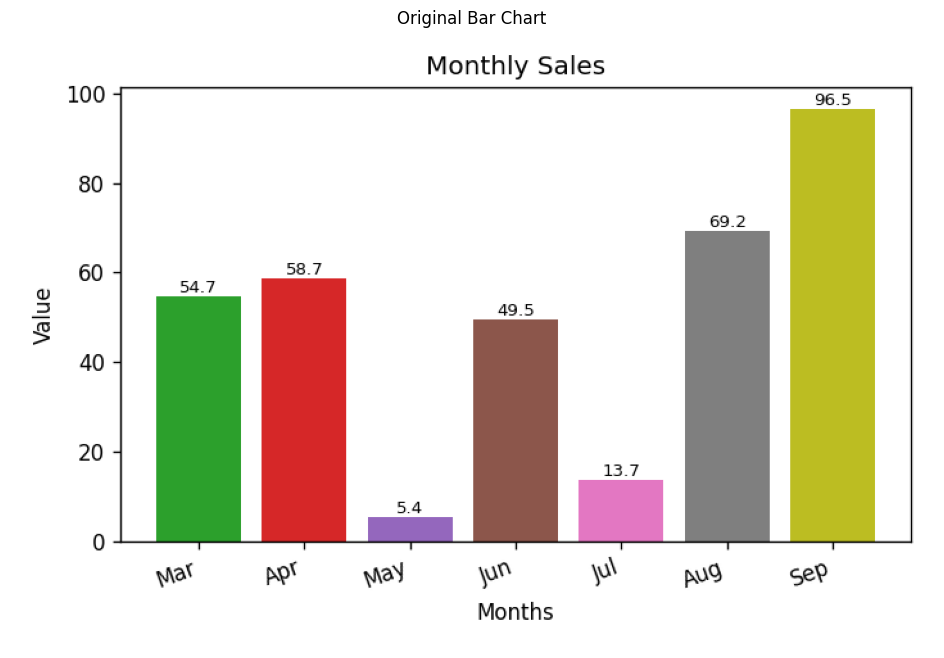

c:\Users\minht\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



=== Extracted Data ===
{
  "chart_type": "bar_chart",
  "title": "Monthly Sales",
  "x_axis_label": "Months",
  "y_axis_label": "Value",
  "data": [
    {
      "category": "Mar",
      "value": 55.43
    },
    {
      "category": "Apr",
      "value": 59.43
    },
    {
      "category": "Jun",
      "value": 50.29
    },
    {
      "category": "Jul",
      "value": 0
    },
    {
      "category": "Aug",
      "value": 70.14
    },
    {
      "category": "Sep",
      "value": 100.0
    }
  ]
}


In [3]:
# Load and display a test chart
image_path = project_root / "data" / "raw" / "bar_charts" / "chart_0001.png"

if image_path.exists():
    # Display original image
    preprocessor = ImagePreprocessor()
    image = preprocessor.load_image(str(image_path))
    
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.title("Original Bar Chart")
    plt.axis('off')
    plt.show()
    
    # Extract data
    try:
        result = extractor.extract(str(image_path), ocr_method='easyocr')
        
        print("\n=== Extracted Data ===")
        print(json.dumps(result, indent=2, ensure_ascii=False))
        
    except Exception as e:
        print(f"Error extracting data: {e}")
        import traceback
        traceback.print_exc()
else:
    print(f"Image not found: {image_path}")
    print("Please run generate_dataset.py first to create test images.")


## Test 2: Visualize Extraction Results


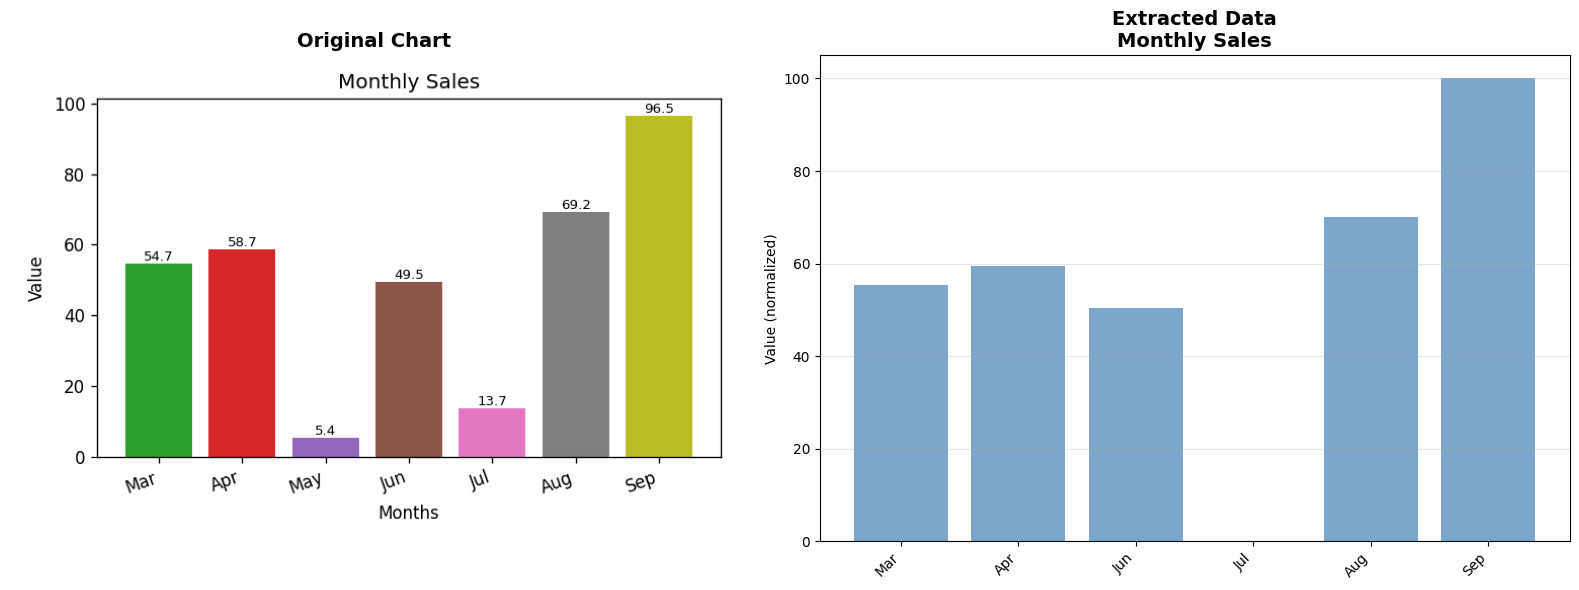


=== Summary ===
Title: Monthly Sales
X-axis label: Months
Y-axis label: Value
Number of bars: 6


In [4]:
# Visualize extracted data
if image_path.exists():
    try:
        result = extractor.extract(str(image_path), ocr_method='easyocr')
        
        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Original chart
        image = preprocessor.load_image(str(image_path))
        ax1.imshow(image)
        ax1.set_title("Original Chart", fontsize=14, fontweight='bold')
        ax1.axis('off')
        
        # Extracted data visualization
        if result['data']:
            categories = [item['category'] for item in result['data']]
            values = [item['value'] for item in result['data']]
            
            ax2.bar(range(len(categories)), values, color='steelblue', alpha=0.7)
            ax2.set_xticks(range(len(categories)))
            ax2.set_xticklabels(categories, rotation=45, ha='right')
            ax2.set_ylabel('Value (normalized)')
            ax2.set_title(f"Extracted Data\n{result.get('title', 'Bar Chart')}", 
                         fontsize=14, fontweight='bold')
            ax2.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary
        print(f"\n=== Summary ===")
        print(f"Title: {result.get('title', 'N/A')}")
        print(f"X-axis label: {result.get('x_axis_label', 'N/A')}")
        print(f"Y-axis label: {result.get('y_axis_label', 'N/A')}")
        print(f"Number of bars: {len(result['data'])}")
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()


## Test 3: Extract Data From Chart And Compare


In [5]:
# Compare extracted data with ground truth annotations
annotation_file = project_root / "data" / "annotations" / "bar_charts.json"

if annotation_file.exists():
    # Load annotations
    with open(annotation_file, 'r', encoding='utf-8') as f:
        annotations = json.load(f)
    
    # Find annotation for chart_0001
    chart_annotation = None
    for ann in annotations:
        if 'chart_0001.png' in ann.get('image', ''):
            chart_annotation = ann
            break
    
    if chart_annotation:
        print("=== Ground Truth ===")
        print(json.dumps(chart_annotation, indent=2, ensure_ascii=False))
        
        # Extract data
        try:
            result = extractor.extract(str(image_path), ocr_method='easyocr')
            
            print("\n=== Extracted Data ===")
            print(json.dumps(result, indent=2, ensure_ascii=False))
            
            # Compare
            print("\n=== Comparison ===")
            gt_metadata = chart_annotation.get('metadata', {})
            print(f"Title - GT: '{gt_metadata.get('title', '')}' | Extracted: '{result.get('title', '')}'")
            print(f"X-label - GT: '{gt_metadata.get('xlabel', '')}' | Extracted: '{result.get('x_axis_label', '')}'")
            print(f"Y-label - GT: '{gt_metadata.get('ylabel', '')}' | Extracted: '{result.get('y_axis_label', '')}'")
            
            gt_categories = gt_metadata.get('categories', [])
            gt_values = gt_metadata.get('values', [])
            extracted_categories = [item['category'] for item in result['data']]
            extracted_values = [item['value'] for item in result['data']]
            
            print(f"\nCategories - GT: {len(gt_categories)} | Extracted: {len(extracted_categories)}")
            print(f"Values - GT: {len(gt_values)} | Extracted: {len(extracted_values)}")
            
        except Exception as e:
            print(f"Error: {e}")
    else:
        print("Annotation not found for chart_0001.png")
else:
    print(f"Annotation file not found: {annotation_file}")


=== Ground Truth ===
{
  "image": "data/raw/bar_charts/chart_0001.png",
  "metadata": {
    "type": "bar_chart",
    "title": "Monthly Sales",
    "xlabel": "Months",
    "ylabel": "Value",
    "categories": [
      "Mar",
      "Apr",
      "May",
      "Jun",
      "Jul",
      "Aug",
      "Sep"
    ],
    "values": [
      54.66,
      58.71,
      5.37,
      49.47,
      13.67,
      69.23,
      96.54
    ],
    "options": {
      "grid": false,
      "value_labels": true,
      "colormap": "tab10"
    }
  }
}


c:\Users\minht\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



=== Extracted Data ===
{
  "chart_type": "bar_chart",
  "title": "Monthly Sales",
  "x_axis_label": "Months",
  "y_axis_label": "Value",
  "data": [
    {
      "category": "Mar",
      "value": 55.43
    },
    {
      "category": "Apr",
      "value": 59.43
    },
    {
      "category": "Jun",
      "value": 50.29
    },
    {
      "category": "Jul",
      "value": 0
    },
    {
      "category": "Aug",
      "value": 70.14
    },
    {
      "category": "Sep",
      "value": 100.0
    }
  ]
}

=== Comparison ===
Title - GT: 'Monthly Sales' | Extracted: 'Monthly Sales'
X-label - GT: 'Months' | Extracted: 'Months'
Y-label - GT: 'Value' | Extracted: 'Value'

Categories - GT: 7 | Extracted: 6
Values - GT: 7 | Extracted: 6


## Test 4: Process Multiple Charts


In [6]:
# Process multiple charts
chart_dir = project_root / "data" / "raw" / "bar_charts"
chart_files = sorted(chart_dir.glob("chart_*.png"))[:5]  # Test first 5 charts

if chart_files:
    results = []
    
    for chart_path in chart_files:
        try:
            result = extractor.extract(str(chart_path), ocr_method='easyocr')
            results.append({
                'file': chart_path.name,
                'title': result.get('title', ''),
                'num_bars': len(result.get('data', [])),
                'success': True
            })
        except Exception as e:
            results.append({
                'file': chart_path.name,
                'error': str(e),
                'success': False
            })
    
    # Display results
    print("=== Batch Processing Results ===\n")
    for res in results:
        if res['success']:
            print(f"✓ {res['file']}")
            print(f"  Title: {res['title'] or 'N/A'}")
            print(f"  Bars: {res['num_bars']}")
        else:
            print(f"✗ {res['file']}")
            print(f"  Error: {res.get('error', 'Unknown')}")
        print()
else:
    print("No chart files found. Please run generate_dataset.py first.")


=== Batch Processing Results ===

✓ chart_0001.png
  Title: Monthly Sales
  Bars: 6

✓ chart_0002.png
  Title: Survey Results
  Bars: 8

✓ chart_0003.png
  Title: Market Share
  Bars: 6

✓ chart_0004.png
  Title: Monthly Sales
  Bars: 6

✓ chart_0005.png
  Title: Quarterly Profits
  Bars: 4



## Test 5: Detailed Component Analysis


=== Component Detection ===
X-axis detected: True
Y-axis detected: True
Bars detected: 6
Text regions detected: 18


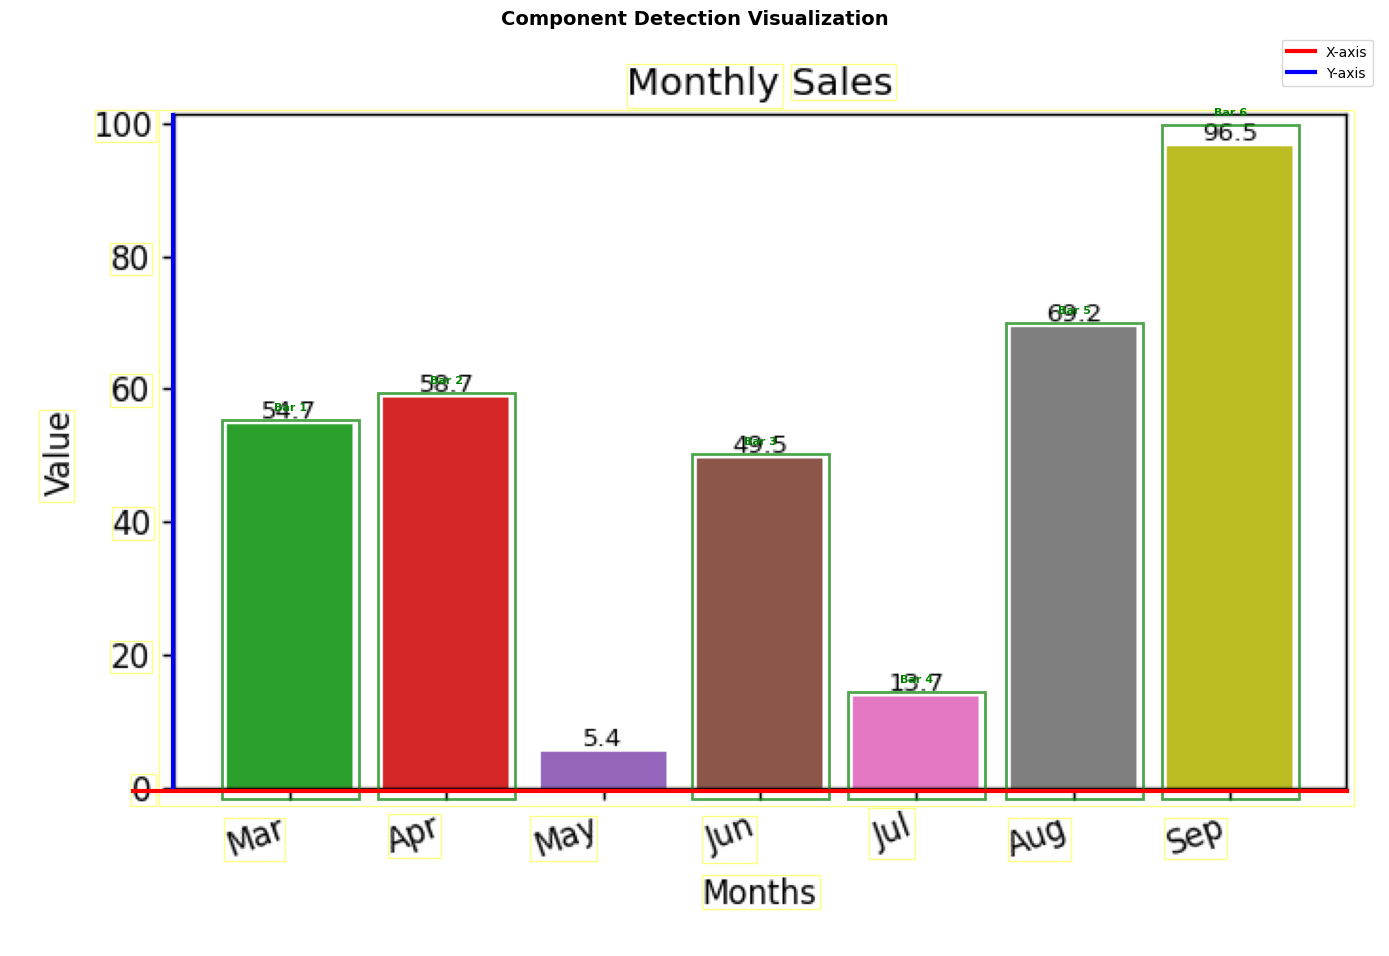


=== Final Extraction Result ===
Chart type: bar_chart
Title: Monthly Sales
Data points: 6
  1. Mar: 55.43
  2. Apr: 59.43
  3. Jun: 50.29
  4. Jul: 0.00
  5. Aug: 70.14


In [7]:
# Detailed analysis of extraction process
if image_path.exists():
    # Load image
    image = preprocessor.load_image(str(image_path))
    
    # Step-by-step analysis
    detector = ChartComponentDetector(preprocessor)
    
    # Detect components
    x_axis, y_axis = detector.detect_axes(image)
    bars = detector.detect_bars(image, x_axis, y_axis)
    text_regions = detector.detect_text_regions(image)
    
    print(f"=== Component Detection ===")
    print(f"X-axis detected: {x_axis is not None}")
    print(f"Y-axis detected: {y_axis is not None}")
    print(f"Bars detected: {len(bars)}")
    print(f"Text regions detected: {len(text_regions)}")
    
    # Visualize components
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.imshow(image)
    
    # Draw axes
    if x_axis is not None:
        x1, y1, x2, y2 = x_axis
        ax.plot([x1, x2], [y1, y2], 'r-', linewidth=3, label='X-axis')
    if y_axis is not None:
        x1, y1, x2, y2 = y_axis
        ax.plot([x1, x2], [y1, y2], 'b-', linewidth=3, label='Y-axis')
    
    # Draw bars
    for i, bar in enumerate(bars):
        x, y, w, h = bar['bbox']
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='green', 
                           facecolor='none', alpha=0.7)
        ax.add_patch(rect)
        ax.text(x + w/2, y - 5, f"Bar {i+1}", ha='center', fontsize=8, 
               color='green', weight='bold')
    
    # Draw text regions
    for x, y, w, h in text_regions:
        rect = plt.Rectangle((x, y), w, h, linewidth=1, edgecolor='yellow', 
                           facecolor='none', alpha=0.5)
        ax.add_patch(rect)
    
    ax.set_title("Component Detection Visualization", fontsize=14, fontweight='bold')
    ax.legend()
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Extract and show final result
    try:
        result = extractor.extract(str(image_path), ocr_method='easyocr')
        print(f"\n=== Final Extraction Result ===")
        print(f"Chart type: {result.get('chart_type')}")
        print(f"Title: {result.get('title', 'N/A')}")
        print(f"Data points: {len(result.get('data', []))}")
        for i, item in enumerate(result.get('data', [])[:5]):  # Show first 5
            print(f"  {i+1}. {item['category']}: {item['value']:.2f}")
    except Exception as e:
        print(f"Error in extraction: {e}")


## Test 6: Export to JSON


In [8]:
# Export extracted data to JSON file
if image_path.exists():
    try:
        result = extractor.extract(str(image_path), ocr_method='easyocr')
        
        # Save to JSON
        output_file = project_root / "data" / "processed" / "extracted_chart_0001.json"
        output_file.parent.mkdir(parents=True, exist_ok=True)
        
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(result, f, indent=2, ensure_ascii=False)
        
        print(f"✓ Extracted data saved to: {output_file}")
        print(f"\nFile contents:")
        print(json.dumps(result, indent=2, ensure_ascii=False))
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()


✓ Extracted data saved to: C:\Homework\Code File\Python Code File\iView\Chart-understanding\bleh\data\processed\extracted_chart_0001.json

File contents:
{
  "chart_type": "bar_chart",
  "title": "Monthly Sales",
  "x_axis_label": "Months",
  "y_axis_label": "Value",
  "data": [
    {
      "category": "Mar",
      "value": 55.43
    },
    {
      "category": "Apr",
      "value": 59.43
    },
    {
      "category": "Jun",
      "value": 50.29
    },
    {
      "category": "Jul",
      "value": 0
    },
    {
      "category": "Aug",
      "value": 70.14
    },
    {
      "category": "Sep",
      "value": 100.0
    }
  ]
}
